In [30]:
import pylsl
import time
from random import random as rand
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import norm

In [31]:
def discrete_sine(t: np.array, f: float, delay: float = 0.0, fs: float = 250.0) -> np.array:
    ''' Generate a sine wave

    Args:
        `t` (`np.array`): Discrete time (n) array

        `f` (`float`): Frequency in Hz

        `delay` (`float`): Delay in discrete time. Default: 0.0

        `fs` (`float`): Sampling rate in Hz. Default: 250.0

    Returns:
        `float`: Sine wave array in discrete time (n)
    '''
    F = f/fs
    return np.sin(2*np.pi*F*(t+delay))

def sum_sines(t: np.array, f_list: list[float], scaling: list[float], delay: float = 0.0, fs: float = 250.0) -> np.array:
    ''' Generate a sine wave

    Args:
        `t` (`np.array`): Discrete time (n) array

        `f_list` (`list[float]`): List of frequencies in Hz

        `scaling` (`list[float]`): List of coefficients to scale each sinusoid

        `delay` (`float`): Delay in discrete time. Default: 0.0

        `fs` (`float`): Sampling rate in Hz. Default: 250.0

    Returns:
        `float`: Sine wave array in discrete time (n)
    '''
    return np.sum([s*discrete_sine(t, f, delay=delay, fs=fs) for f, s in list(zip(f_list, scaling))], axis=0)

def generate_eeg(n_seconds: float = 4.0, delay: float = 0.0, fs: float = 250.0, noise=True) -> np.array:
    # num_samples = int(fs*n_seconds)
    num_samples = 1

    frequencies = [60, 120, 180]
    scaling = norm.pdf(frequencies, 60, 50)
    scaling /= scaling[0]
    scaling *= 0.25
    scaling = list(scaling)

    # 4 to 7 for theta
    # 12.5 to 30 for beta
    target_bands = [(3, 8), (12, 32)]

    for lower_bound, upper_bound in target_bands:
        band_frequencies = []
        for freq in np.arange(lower_bound, upper_bound, step=1):
            band_frequencies.append(freq)

        frequencies.extend(band_frequencies)
        scaling.extend(list(norm.pdf(band_frequencies, (upper_bound + lower_bound)/2.0, 1)))

    print(list(zip(frequencies, scaling)))

    t = np.array([*range(num_samples)])
    signal = sum_sines(t, frequencies, fs=fs, scaling=scaling, delay=delay)

    if noise:
        mu = 0.0
        std = 0.4 * np.std(signal)
        noise = np.random.normal(mu, std, size=signal.shape)

        signal += noise

    return signal[0]



In [32]:
# Sampling rate Hz (Cyton board)
fs = 250

seconds = 4

t, ch1 = generate_eeg()

plt.plot(t, ch1)
plt.title(f'EEG signal ({seconds} second window)')
plt.xlabel('Time (n)')
plt.ylabel('Magnitude')
plt.vlines(1000, -1, 1, color='red')

[(60, 0.25), (120, 0.12168806398999293), (180, 0.014033690708533431), (3, 0.01752830049356854), (4, 0.12951759566589174), (5, 0.3520653267642995), (6, 0.3520653267642995), (7, 0.12951759566589174), (12, 7.69459862670642e-23), (13, 1.0279773571668917e-18), (14, 5.052271083536893e-15), (15, 9.134720408364595e-12), (16, 6.075882849823286e-09), (17, 1.4867195147342979e-06), (18, 0.00013383022576488537), (19, 0.0044318484119380075), (20, 0.05399096651318806), (21, 0.24197072451914337), (22, 0.3989422804014327), (23, 0.24197072451914337), (24, 0.05399096651318806), (25, 0.0044318484119380075), (26, 0.00013383022576488537), (27, 1.4867195147342979e-06), (28, 6.075882849823286e-09), (29, 9.134720408364595e-12), (30, 5.052271083536893e-15), (31, 1.0279773571668917e-18)]


TypeError: cannot unpack non-iterable numpy.float64 object

/home/anderson/miniconda3/envs/crux/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


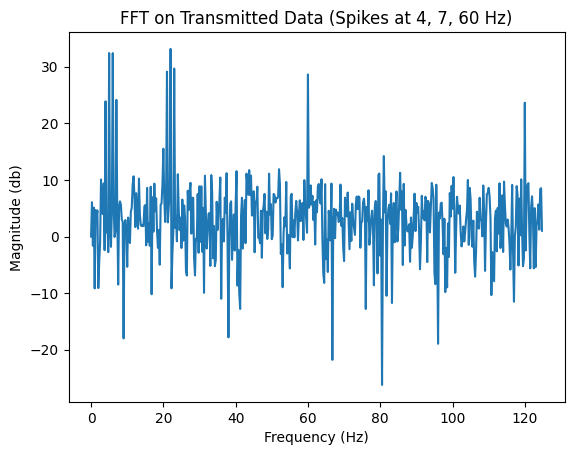

In [ ]:
# Sample count
N = len(ch1)
# Sampling rate
fs = 250

# Sample spacing (inverse of sampling rate)
df = 1/fs

'''
FFT and frequency time scale
Halve the frequency domain due to real-time signal conjugate symmetry
'''
yf = fft(ch1)[:N//2]
xf = fftfreq(N, df)[:N//2]

'''
Convert power signal to normalized decibel
'''
yf_plot = 20*np.log10(np.abs(yf)/np.max(yf))
yf_plot -= yf_plot[0]

plt.title('FFT on Transmitted Data (Spikes at 4, 7, 60 Hz)')
plt.ylabel('Magnitude (db)')
plt.xlabel('Frequency (Hz)')
plt.plot(xf, yf_plot)

In [46]:
name = 'bci'
stream_type = 'EEG'
channel_names = ["Fp1", "Fp2"]
n_channels = 1#len(channel_names)

info = pylsl.StreamInfo(name, stream_type, n_channels, fs, 'float32', 'myuid2424')

# info.desc().append_child_value("manufacturer", "LSLExampleAmp")
# chns = info.desc().append_child("channels")
# for chan_ix, label in enumerate(channel_names):
#     ch = chns.append_child("channel")
#     ch.append_child_value("label", label)
#     ch.append_child_value("unit", "microvolts")
#     ch.append_child_value("type", "EEG")
#     ch.append_child_value("scaling_factor", "1")
#     loc = ch.append_child("location")

outlet = pylsl.StreamOutlet(info, 32, 320)
print("now sending data...")
start_time = pylsl.local_clock()
sent_samples = 0
while True:
    elapsed_time = pylsl.local_clock() - start_time
    required_samples = int(fs * elapsed_time) - sent_samples
    if required_samples > 0:
        mychunk = [generate_eeg(delay=elapsed_time) for _ in range(8)]
        # print(mychunk)
        # print(mychunk)
        # for _ in range(required_samples):
        #     mychunk.append([])
        # print(len(mychunk))
        # Get a time stamp in seconds. We pretend that our samples are actually
        # 125ms old, e.g., as if coming from some external hardware with known latency.
        stamp = pylsl.local_clock() - 0.125
        # now send it and wait for a bit

        # the `push_chunk` method will convert it to c_float before passing the data to liblsl.
        outlet.push_chunk(mychunk, stamp)
        sent_samples += required_samples
    time.sleep(0.02)

2023-04-19 21:49:13.647 (1617.283s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fdc3:6f7d:1e74:4c95:f2e5:4f17:321d:ae52 (Address already in use)
2023-04-19 21:49:13.647 (1617.283s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2607:f010:2a7:1003:30cf:6a86:80c8:69b (Address already in use)
2023-04-19 21:49:13.647 (1617.283s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2607:f010:2a7:1003:d6e8:46d:e4ca:a221 (Address already in use)
2023-04-19 21:49:13.647 (1617.283s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::364a:1f8b:8dcd:822d%wlp0s20f3 (Address already in use)
2023-04-19 21:49:13.

now sending data...
[(60, 0.25), (120, 0.12168806398999293), (180, 0.014033690708533431), (3, 0.01752830049356854), (4, 0.12951759566589174), (5, 0.3520653267642995), (6, 0.3520653267642995), (7, 0.12951759566589174), (12, 7.69459862670642e-23), (13, 1.0279773571668917e-18), (14, 5.052271083536893e-15), (15, 9.134720408364595e-12), (16, 6.075882849823286e-09), (17, 1.4867195147342979e-06), (18, 0.00013383022576488537), (19, 0.0044318484119380075), (20, 0.05399096651318806), (21, 0.24197072451914337), (22, 0.3989422804014327), (23, 0.24197072451914337), (24, 0.05399096651318806), (25, 0.0044318484119380075), (26, 0.00013383022576488537), (27, 1.4867195147342979e-06), (28, 6.075882849823286e-09), (29, 9.134720408364595e-12), (30, 5.052271083536893e-15), (31, 1.0279773571668917e-18)]
[(60, 0.25), (120, 0.12168806398999293), (180, 0.014033690708533431), (3, 0.01752830049356854), (4, 0.12951759566589174), (5, 0.3520653267642995), (6, 0.3520653267642995), (7, 0.12951759566589174), (12, 7.694